In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Intro to FITS Files

Flexible Image Transport System (FITS) is a standard file format widely used in astronomy for storing scientific data, particularly images and multi-dimensional arrays. FITS files are designed to preserve both the raw data and metadata in a structured way. A typical FITS file will contain one or more Header Data Units (HDUs)—each consisting of a header (with keyword-value pairs describing the data) and data (which can be an image, table, etc.).

Below we go through an example of working with FITS files using a Hubble observation of the butterfly nebula, which is a planetary nebula located in the constellation Scorpius. It earns it name due to its distinctive appearance, with "wings" of gas resulting from a dying star located at its center that has shed layers of gas over time. 

In [2]:
butterfly_nebula = "butterfly_nebula_hubble_rebinned.fits.gz" #path to fits file (fits.gz is just a compressed version of a fits file) 

In [3]:
fits.info(butterfly_nebula) #gives you information about the fits file; this fits file has only one HDU 

Filename: butterfly_nebula_hubble_rebinned.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     579   (800, 700, 3)   float64   


In [4]:
#acessing the header 
hdul= fits.open(butterfly_nebula) # opening a fits file gives you the list of HDUs
header = hdul[0].header # gets header of the primary hdu (which is at index zero)
hdul.close() #closing a fits file 

Headers within FITS files typically store important information about the data held in the associated HDU. The header below contains information related to the source observed, conditions when the observations were taken, and other general notes. You can access information stored in the header directly by indexing using the associated keyword. 

In [5]:
header 

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  800                                                  
NAXIS2  =                  700                                                  
NAXIS3  =                    3                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2025-05-05T03:27:58' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
OBJECT  = 'NGC 6302 in S II'   / Name of the object observed                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '17:16:44 (03/09/2009)' / Time of last modification                   
NEXTEND =                   

In [6]:
#acessing information stored in keywords of the header 
print(header["RA_TARG"]) 
print(header["DEC_TARG"]) 

258.4312254167
-37.10384166667


In [7]:
# acessing data stored within a fits file 
hdul = fits.open(butterfly_nebula)
data = hdul[0].data #data stored in No. 0 (the primary HDU)
print(data.shape) # 3 filters stored as 3D cube 
filter_1 = data[0,:,:] #getting data from the first filter
hdul.close()

(3, 700, 800)


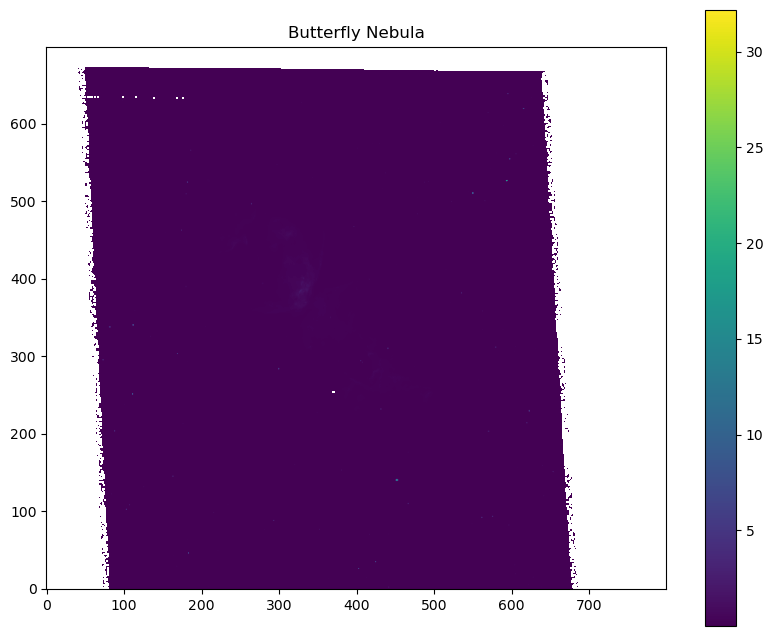

In [8]:
# without setting limits on the colormap/setting a stretch, it's hard to see the nebula
plt.figure(figsize=(10, 8))
plt.imshow(filter_1, cmap='viridis', origin='lower') #plots 2d data, cmap sets the colormap to use, origin='lower' gets you pixel (0,0) in the lower left corner
plt.colorbar()
plt.title("Butterfly Nebula")
plt.show()

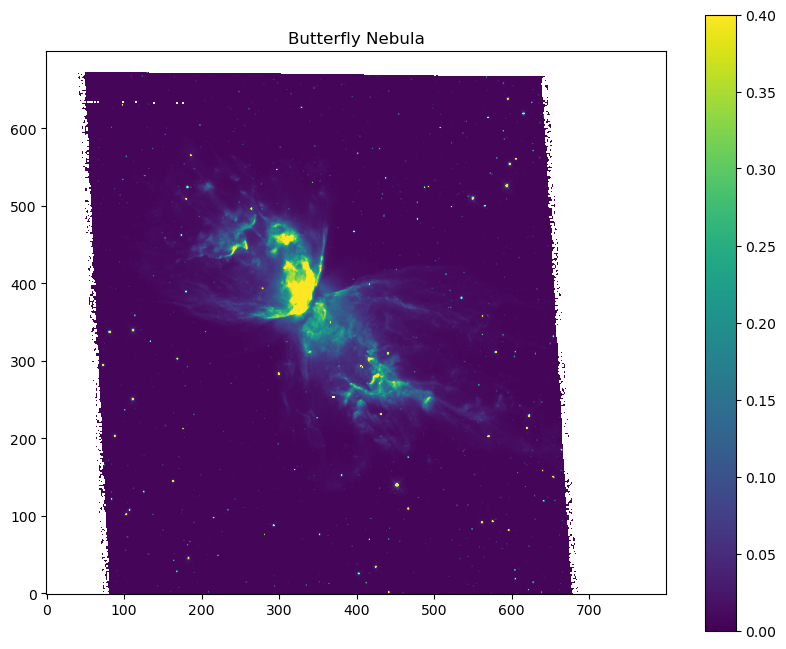

In [9]:
# we start to see the nebula after setting limits on the colormap range
plt.figure(figsize=(10, 8))
plt.imshow(filter_1, cmap='viridis', origin='lower', vmin=0, vmax=0.4) #vmin, vmax sets the min/max values to scale the color map to
plt.colorbar()
plt.title("Butterfly Nebula")
plt.show()

Astronomical images often have large dynamic ranges and it can be very difficult to see faint emission without the use of cuts/stretches. Thankfully, astropy.visualization hosts a range of useful stretch functions, including SqrtStretch, LogStretch, etc. The syntax to use them is as follows:

In [10]:
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch, LogStretch, LinearStretch # functions to help with visualizing data  

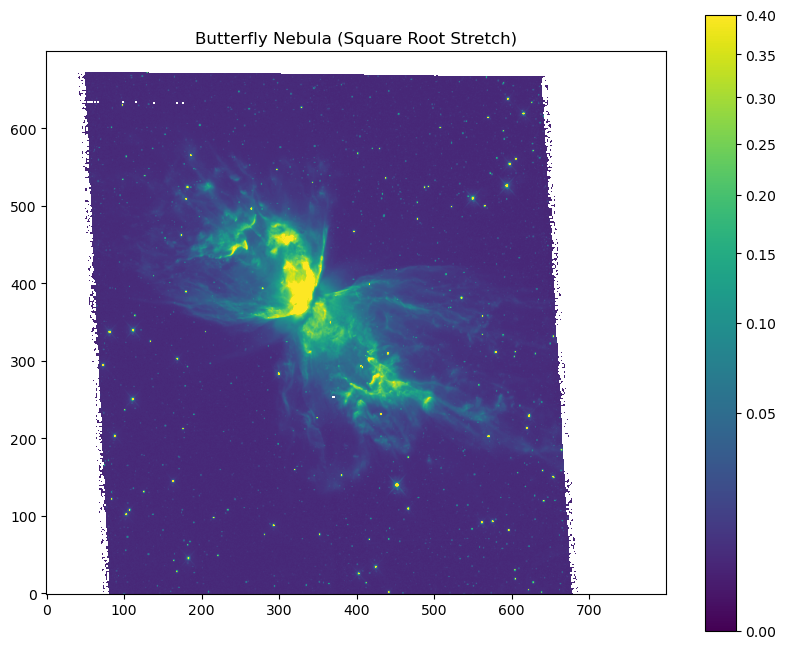

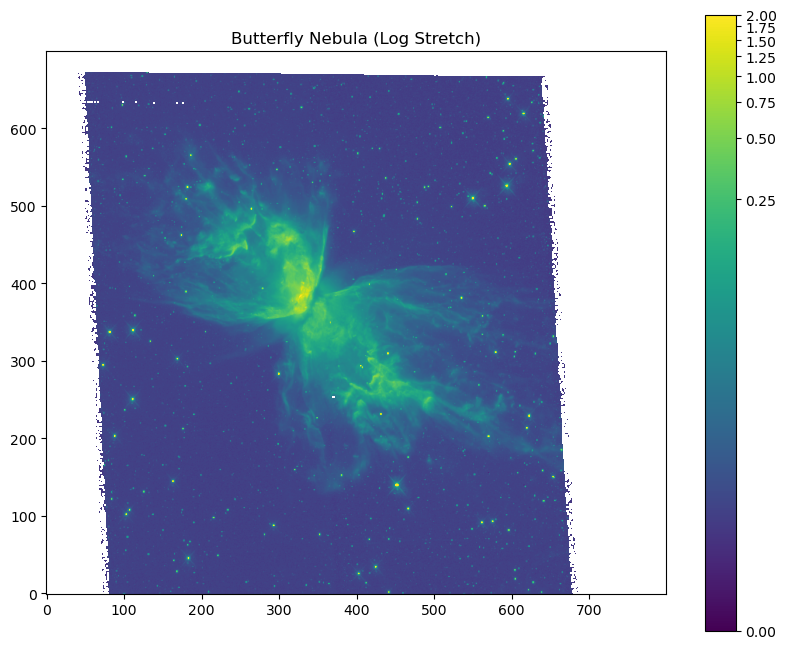

In [11]:
norm_sqrt = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.4) #defines a square root stretch that we can apply to the image; the minimum and maximum pixel values for the colorbar lie in [0,0.4]

# can see fainter emission using these stretches
plt.figure(figsize=(10, 8))
plt.imshow(filter_1, cmap='viridis', origin='lower', norm=norm_sqrt) #plot 2d data with normalization defined by norm_sqrt
plt.colorbar()
plt.title("Butterfly Nebula (Square Root Stretch)")
plt.show()

norm_log=  ImageNormalize(stretch=LogStretch(), vmin=0, vmax=2) #defines a log stretch we can apply to the image; the minimum and maximum pixel values for the colorbar lie in [0,2]
plt.figure(figsize=(10, 8))
plt.imshow(filter_1, cmap='viridis', origin='lower', norm=norm_log) #plot 2d data with normalization defined by norm_log
plt.colorbar()
plt.title("Butterfly Nebula (Log Stretch)")
plt.show()

# Computing basic statistics on data 

Often, you will need to compute basic statistics on an image or an array of data points. Real astronomical data can be filled with NaNs where there is no data. These happens frequently since observations are not always done on a perfect square field/different observations can have different footprints. If you try to use typical numpy functions such as np.mean/np.maximum on data with NaNs you will get NaN back. Thankfully, there is a set of numpy functions that ignore NaNs and compute the statistic requested on the remaining pixels (i.e. np.nanmean, np.nanmedian, np.nanmin, np.nanmax, etc.). We can see these functions in action below:

In [12]:
print("Mean=", np.mean(filter_1)) # does not ignore NaNs
print("Median=", np.median(filter_1))  # does not ignore NaNs

Mean= nan
Median= nan


In [13]:
print("Let's try the functions that ignore NaNs:")
print("Mean=", np.nanmean(filter_1))
print("Median=", np.nanmedian(filter_1))
print("Maximum Pixel Value=", np.nanmax(filter_1)) 
print("Minimum Pixel Value=", np.nanmin(filter_1))

Let's try the functions that ignore NaNs:
Mean= 0.020718175472283065
Median= 0.0061213437002152205
Maximum Pixel Value= 32.17539978027344
Minimum Pixel Value= 0.0002863513072952628


In [14]:
#to compute median across each column in an image
filter1_data_without_NaNs = filter_1[0:650,100:670] # first slice to get data free from NaNs (to avoid getting columns completely full of NaNs)

mean_of_each_col = np.nanmedian(filter1_data_without_NaNs, axis=0) #Find the Median across each column with axis=0 (axis=1 gives the median across each row)

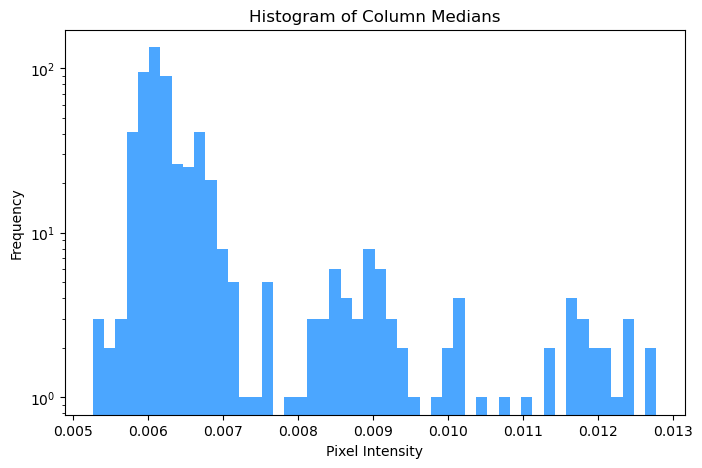

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(mean_of_each_col, bins=50, color="dodgerblue", alpha=0.8) #plotting a histogram of the array of medians where bins=50 gives 50 total bins in our histogram

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Column Medians")
plt.yscale('log')  # use log scale to see low-frequency bins

plt.show()

# FITS File Excercise

Extract the Target Name, Sun Angle and Moon Angle from the header.

Open the fits file provided again using the same syntax. The primary HDU contains data whose shape is (3,700,800) where the 3 represents images of the butterfly nebula from three different hubble filters. Store data from the second and third filter as filter_2 and filter_3 respectively.

Plot filter_2 and filter_3 using stretches that showcase features of the butterfly nebula. Be sure to adjust vmin/vmax as necessary.

Extract the overall mean and median in each filter. Likewise, find the maximum and minimum pixel values in each filter. Finally, plot a histogram which shows the distribution of the median of each row in filter_2 and filter_3.

The combination of the three filters you extracted from the FITS files can be used to make a three-color image. This in general is how astronomers generate colorful pictures of astronomical observations!  

In [26]:
from astropy.visualization import make_lupton_rgb # function used to generate three-color images in python

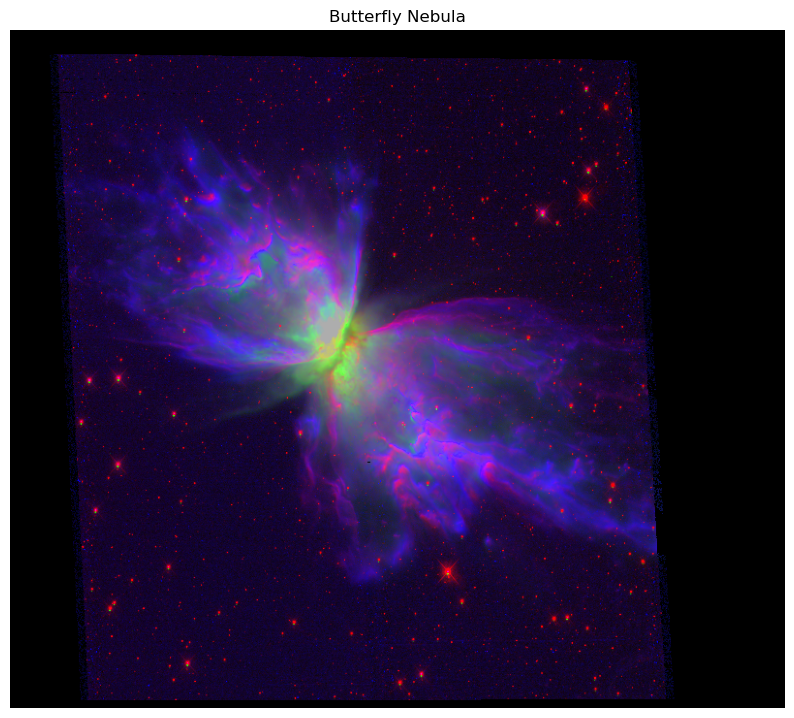

In [27]:
interval = PercentileInterval(99.5)  # a way to clip top/bottom 0.25% and keep 99.5% of the original data; this can be applied to our data in each filter 
filter_2 = data[1,:,:] #equivalent to what you did above! 
filter_3 = data[2,:,:] #equivalent to what you did above! 

rgb_image = make_lupton_rgb(interval(filter_1), # your reddest filter (shows up as red in final image)
                            interval(filter_2), # your intermediate filter (shows up as green in final image)
                            interval(filter_3), # your bluest filter (shows up as blue in final image)
                            Q=10, stretch=0.05) # parameters that adjust the stretch to make features visible 

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.axis('off') #removes the axes with the pixel numbers labeled
plt.title("Butterfly Nebula")
plt.show()